# COSMOS Tutorial: Mouse Olfactory Bulb (MOB) Dataset

## Dataset Overview
- **Tissue**: Mouse Olfactory Bulb (MOB)
- **Technology**: Spatial transcriptomics
- **Cells**: ~3000-5000 cells (estimated)
- **Layers**: ONL (Outer Nuclear Layer) + others
- **Goal**: Compare GCN vs Graph Transformer + PE performance

## Modality Split Strategy
Since we only have gene expression data, we'll split genes into two artificial modalities:
- **Modality 1**: High variance genes (top 50%)
- **Modality 2**: Remaining genes (bottom 50%)

This simulates multi-modal integration and is a common practice for testing spatial integration methods.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import sklearn.metrics
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Load and Explore MOB Data

In [4]:
# Load data
counts = pd.read_csv('./MOB_counts.csv', index_col=0)
metadata = pd.read_csv('./MOB_meta.csv', index_col=0)

print(f"Counts shape: {counts.shape}")
print(f"Metadata shape: {metadata.shape}")
print(f"\nMetadata columns: {metadata.columns.tolist()}")
print(f"\nLayer types: {metadata['Layertype'].unique()}")
print(f"Number of cells per layer:")
print(metadata['Layertype'].value_counts())

Counts shape: (18196, 3000)
Metadata shape: (18196, 3)

Metadata columns: ['Layertype', 'x_pos', 'y_pos']

Layer types: ['ONL' 'GL' 'EPL' 'MCL' 'GCL/IPL' 'RMS']
Number of cells per layer:
Layertype
GCL/IPL    6764
EPL        3585
GL         2987
ONL        2289
MCL        1447
RMS        1124
Name: count, dtype: int64


In [5]:
# Extract spatial coordinates
spatial_coords = metadata[['x_pos', 'y_pos']].values

# Get layer annotations
layer_annotations = metadata['Layertype'].values

print(f"Spatial coordinates shape: {spatial_coords.shape}")
print(f"Coordinate range:")
print(f"  X: [{spatial_coords[:, 0].min():.2f}, {spatial_coords[:, 0].max():.2f}]")
print(f"  Y: [{spatial_coords[:, 1].min():.2f}, {spatial_coords[:, 1].max():.2f}]")

Spatial coordinates shape: (18196, 2)
Coordinate range:
  X: [10171.41, 14831.60]
  Y: [6307.39, 12136.68]


## 2. Visualize Ground Truth Annotations

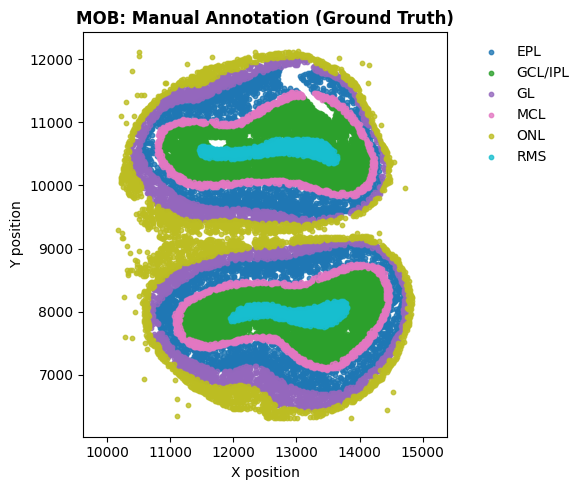

✓ Ground truth visualization complete


In [6]:
# Plot ground truth spatial distribution
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

# Get unique layers and assign colors
unique_layers = np.unique(layer_annotations)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_layers)))
layer_to_color = dict(zip(unique_layers, colors))

for layer in unique_layers:
    mask = layer_annotations == layer
    ax.scatter(spatial_coords[mask, 0], spatial_coords[mask, 1], 
               c=[layer_to_color[layer]], label=layer, s=10, alpha=0.8)

ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_title('MOB: Manual Annotation (Ground Truth)', fontsize=12, fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
ax.axis('equal')
plt.tight_layout()
plt.show()

print(f"✓ Ground truth visualization complete")

## 3. Preprocess and Split Data into Two Modalities

We'll split genes based on variance:
- **Modality 1**: High-variance genes (informative)
- **Modality 2**: Lower-variance genes (complementary)

In [7]:
# Create AnnData object for initial processing
adata_full = sc.AnnData(counts.values)
adata_full.obs['Layertype'] = layer_annotations
adata_full.obsm['spatial'] = spatial_coords
adata_full.var_names = counts.columns
adata_full.obs_names = counts.index

print(f"Full dataset: {adata_full.shape}")

# Basic preprocessing
sc.pp.normalize_total(adata_full, target_sum=1e4)
sc.pp.log1p(adata_full)

# Calculate gene variance
gene_var = np.var(adata_full.X, axis=0)
if hasattr(gene_var, 'A1'):  # Handle sparse matrices
    gene_var = gene_var.A1

# Split genes by variance
n_genes = len(gene_var)
var_threshold = np.median(gene_var)

high_var_genes = gene_var >= var_threshold
low_var_genes = ~high_var_genes

print(f"\nGene split:")
print(f"  Modality 1 (high variance): {high_var_genes.sum()} genes")
print(f"  Modality 2 (low variance): {low_var_genes.sum()} genes")

Full dataset: (18196, 3000)

Gene split:
  Modality 1 (high variance): 1500 genes
  Modality 2 (low variance): 1500 genes


In [8]:
# Create two modality AnnData objects
# Modality 1: High variance genes
if hasattr(adata_full.X, 'toarray'):
    data1 = adata_full.X.toarray()[:, high_var_genes]
    data2 = adata_full.X.toarray()[:, low_var_genes]
else:
    data1 = adata_full.X[:, high_var_genes]
    data2 = adata_full.X[:, low_var_genes]

adata1 = sc.AnnData(data1, dtype='float64')
adata1.obs['Layertype'] = layer_annotations
adata1.obsm['spatial'] = spatial_coords
adata1.obs['x_pos'] = spatial_coords[:, 0]
adata1.obs['y_pos'] = spatial_coords[:, 1]

# Modality 2: Lower variance genes
adata2 = sc.AnnData(data2, dtype='float64')
adata2.obs['Layertype'] = layer_annotations
adata2.obsm['spatial'] = spatial_coords
adata2.obs['x_pos'] = spatial_coords[:, 0]
adata2.obs['y_pos'] = spatial_coords[:, 1]

print(f"\nModality 1 shape: {adata1.shape}")
print(f"Modality 2 shape: {adata2.shape}")
print(f"\n✓ Data split into two modalities")


Modality 1 shape: (18196, 1500)
Modality 2 shape: (18196, 1500)

✓ Data split into two modalities


## 4. Assess Data Complexity

Let's determine if this is complex (like MouseBrain) or simple (like VisualCortex)

In [9]:
# Compute spatial autocorrelation (Moran's I)
from sklearn.neighbors import kneighbors_graph
from scipy.stats import pearsonr

def compute_spatial_autocorrelation(coords, values, k=10):
    """Compute Moran's I for spatial autocorrelation"""
    # Build spatial weights matrix
    W = kneighbors_graph(coords, k, mode='connectivity')
    W = W.toarray()
    
    # Normalize
    W = W / W.sum(axis=1, keepdims=True)
    
    # Compute Moran's I
    n = len(values)
    mean_val = values.mean()
    
    numerator = 0
    denominator = ((values - mean_val) ** 2).sum()
    
    for i in range(n):
        for j in range(n):
            numerator += W[i, j] * (values[i] - mean_val) * (values[j] - mean_val)
    
    moran_i = (n / W.sum()) * (numerator / denominator)
    return moran_i

# Encode layers as numeric
layer_numeric = pd.Categorical(layer_annotations).codes
moran_i = compute_spatial_autocorrelation(spatial_coords, layer_numeric)

print(f"Spatial Autocorrelation (Moran's I): {moran_i:.3f}")
print(f"\nInterpretation:")
if moran_i > 0.7:
    print("  → HIGH spatial structure (layered, like VisualCortex)")
    print("  → Recommendation: GCN may perform better")
    print("  → For GT+PE: use num_heads=2, dropout=0.3, use_pe=False")
    complexity = "simple"
elif moran_i > 0.4:
    print("  → MODERATE spatial structure")
    print("  → Recommendation: Test both GCN and GT+PE")
    complexity = "moderate"
else:
    print("  → LOW spatial structure (complex, like MouseBrain)")
    print("  → Recommendation: GT+PE likely to perform better")
    print("  → For GT+PE: use num_heads=8, dropout=0.1, use_pe=True")
    complexity = "complex"

Spatial Autocorrelation (Moran's I): 0.823

Interpretation:
  → HIGH spatial structure (layered, like VisualCortex)
  → Recommendation: GCN may perform better
  → For GT+PE: use num_heads=2, dropout=0.3, use_pe=False


## 5. Run COSMOS with GCN (Baseline)

In [10]:
# Import original COSMOS with GCN
from COSMOS.cosmos import Cosmos as Cosmos_GCN

print("=" * 60)
print("TRAINING: GCN (Original COSMOS)")
print("=" * 60)

# Create COSMOS model
cosmos_gcn = Cosmos_GCN(adata1=adata1, adata2=adata2)
cosmos_gcn.preprocessing_data(n_neighbors=10)

# Train
embedding_gcn = cosmos_gcn.train(
    spatial_regularization_strength=0.01,
    z_dim=50,
    lr=1e-3,
    wnn_epoch=100,  # Compute WNN earlier
    total_epoch=1000,
    max_patience_bef=10,
    max_patience_aft=30,
    min_stop=200,
    random_seed=random_seed,
    gpu=0,
    regularization_acceleration=True,
    edge_subset_sz=1000000
)

weights_gcn = cosmos_gcn.weights
df_embedding_gcn = pd.DataFrame(embedding_gcn)

print(f"\n✓ GCN training complete")
print(f"✓ Embedding shape: {df_embedding_gcn.shape}")

TRAINING: GCN (Original COSMOS)
Epoch 1/1000, Loss: 1.4008735418319702
Epoch 11/1000, Loss: 1.3548405170440674
Epoch 21/1000, Loss: 1.1972397565841675
Epoch 31/1000, Loss: 0.8392906188964844
Epoch 41/1000, Loss: 0.46717894077301025
Epoch 51/1000, Loss: 0.22516974806785583
Epoch 61/1000, Loss: 0.12069567292928696
Epoch 71/1000, Loss: 0.08068311959505081
Epoch 81/1000, Loss: 0.04944923520088196
Epoch 91/1000, Loss: 0.04161711409687996
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 18196 0.00 seconds elapsed
2000 out of 18196 9.29 seconds elapsed
4000 out of 18196 18.77 seconds elapsed
6000 out of 18196 28.35 seconds elapsed
8000 out of 18196 37.57 seconds elapsed
10000 out of 18196 46.62 seconds elapsed
12000 out of 18196 55.91 seconds elapsed
14000 out of 18196 65.47 seconds elapsed
16000 out of 18196 74.79 seconds elapsed
18000 out of 18196 84.22 s

## 6. Run COSMOS with Graph Transformer + PE

In [11]:
# Import Graph Transformer version
from COSMOS.cosmos_transformer_pe_version import Cosmos as Cosmos_GT_PE

print("=" * 60)
print("TRAINING: Graph Transformer + Positional Encoding")
print("=" * 60)

# Set hyperparameters based on data complexity
if complexity == "simple":
    # For layered/simple data
    num_heads = 2
    dropout = 0.3
    use_pe = False
    pe_dim = 0
    print("Using SIMPLE data parameters (no PE, fewer heads)")
elif complexity == "complex":
    # For complex/heterogeneous data
    num_heads = 8
    dropout = 0.1
    use_pe = True
    pe_dim = 8
    print("Using COMPLEX data parameters (with PE, more heads)")
else:
    # Moderate - try with PE
    num_heads = 4
    dropout = 0.2
    use_pe = True
    pe_dim = 8
    print("Using MODERATE data parameters")

# Create COSMOS model
cosmos_gt_pe = Cosmos_GT_PE(adata1=adata1, adata2=adata2)
cosmos_gt_pe.preprocessing_data(n_neighbors=10)

# Train
embedding_gt_pe = cosmos_gt_pe.train(
    spatial_regularization_strength=0.01,
    z_dim=50,
    lr=1e-3,
    wnn_epoch=100,  # Compute WNN earlier
    total_epoch=1000,
    max_patience_bef=10,
    max_patience_aft=30,
    min_stop=200,
    random_seed=random_seed,
    gpu=0,
    regularization_acceleration=True,
    edge_subset_sz=1000000,
    # Graph Transformer parameters
    num_heads=num_heads,
    dropout=dropout,
    pe_dim=pe_dim,
    use_pe=use_pe
)

weights_gt_pe = cosmos_gt_pe.weights
df_embedding_gt_pe = pd.DataFrame(embedding_gt_pe)

print(f"\n✓ GT+PE training complete")
print(f"✓ Embedding shape: {df_embedding_gt_pe.shape}")

TRAINING: Graph Transformer + Positional Encoding
Using SIMPLE data parameters (no PE, fewer heads)
✓ Preprocessing complete:
  - Cells: 18196
  - Modality 1 features: 1500
  - Modality 2 features: 1500
  - Spatial neighbors: 10

COSMOS: Graph Transformer + Positional Encoding
Architecture:
  - Model: Graph Transformer
  - Attention heads: 2
  - Dropout: 0.3
  - Positional Encoding: ✗ Disabled
  - Output dimension: 50

Training:
  - Total epochs: 1000
  - WNN computation at epoch: 100
  - Learning rate: 0.001
  - Spatial regularization: 0.01
  - Device: cuda:0
  - Random seed: 42

Starting training...
Epoch 1/1000, Loss: 1.391170
Epoch 11/1000, Loss: 1.388415
Epoch 21/1000, Loss: 1.370762
Epoch 31/1000, Loss: 1.072216
Epoch 41/1000, Loss: 0.653344
Epoch 51/1000, Loss: 0.408381
Epoch 61/1000, Loss: 0.251422
Epoch 71/1000, Loss: 0.149704
Epoch 81/1000, Loss: 0.111719
Epoch 91/1000, Loss: 0.082474
Computing KNN distance matrices using default Scanpy implementation
Computing modality weigh

## 7. Clustering and Evaluation - GCN

In [12]:
# Create AnnData for clustering (GCN)
adata_result_gcn = adata1.copy()
embedding_adata_gcn = sc.AnnData(df_embedding_gcn)

# Compute neighbors
sc.pp.neighbors(embedding_adata_gcn, n_neighbors=50, use_rep='X')

# Find optimal clustering resolution
best_ari_gcn = 0
best_res_gcn = 0.5

for res in [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]:
    sc.tl.louvain(embedding_adata_gcn, resolution=res)
    clusters = embedding_adata_gcn.obs['louvain']
    ari = sklearn.metrics.adjusted_rand_score(layer_annotations, clusters)
    if ari > best_ari_gcn:
        best_ari_gcn = ari
        best_res_gcn = res

print(f"GCN - Best ARI: {best_ari_gcn:.3f} at resolution {best_res_gcn}")

# Cluster with best resolution
sc.tl.louvain(embedding_adata_gcn, resolution=best_res_gcn)
adata_result_gcn.obs['Cluster_gcn'] = list(embedding_adata_gcn.obs['louvain'])
adata_result_gcn.obs['Cluster_gcn'] = adata_result_gcn.obs['Cluster_gcn'].astype('category')

GCN - Best ARI: 0.617 at resolution 0.5


## 8. Clustering and Evaluation - GT+PE

In [13]:
# Create AnnData for clustering (GT+PE)
adata_result_gt_pe = adata1.copy()
embedding_adata_gt_pe = sc.AnnData(df_embedding_gt_pe)

# Compute neighbors
sc.pp.neighbors(embedding_adata_gt_pe, n_neighbors=50, use_rep='X')

# Find optimal clustering resolution
best_ari_gt_pe = 0
best_res_gt_pe = 0.5

for res in [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0]:
    sc.tl.louvain(embedding_adata_gt_pe, resolution=res)
    clusters = embedding_adata_gt_pe.obs['louvain']
    ari = sklearn.metrics.adjusted_rand_score(layer_annotations, clusters)
    if ari > best_ari_gt_pe:
        best_ari_gt_pe = ari
        best_res_gt_pe = res

print(f"GT+PE - Best ARI: {best_ari_gt_pe:.3f} at resolution {best_res_gt_pe}")

# Cluster with best resolution
sc.tl.louvain(embedding_adata_gt_pe, resolution=best_res_gt_pe)
adata_result_gt_pe.obs['Cluster_gt_pe'] = list(embedding_adata_gt_pe.obs['louvain'])
adata_result_gt_pe.obs['Cluster_gt_pe'] = adata_result_gt_pe.obs['Cluster_gt_pe'].astype('category')

GT+PE - Best ARI: 0.348 at resolution 0.3


## 9. Visualization: Spatial Clustering Results

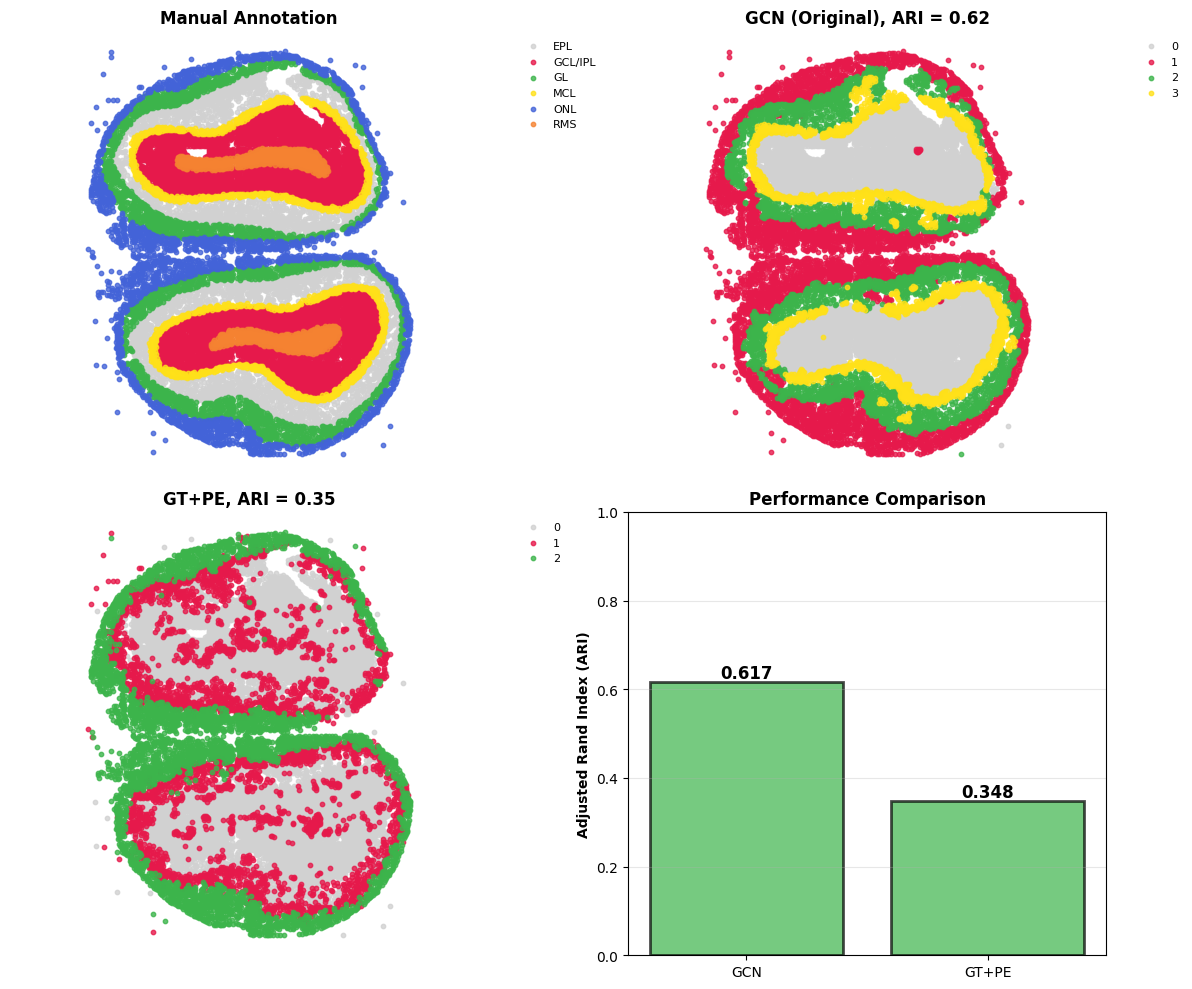


FINAL RESULTS: MOB Dataset
GCN (Original):         ARI = 0.617
GT+PE (Enhanced):       ARI = 0.348
Improvement:            -43.6%


In [14]:
# Plot comparison
matplotlib.rcParams['font.size'] = 10
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_colors = ['#D1D1D1', '#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
               '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080',
               '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000']

# Ground truth
ax = axes[0, 0]
for i, layer in enumerate(np.unique(layer_annotations)):
    mask = layer_annotations == layer
    ax.scatter(spatial_coords[mask, 0], spatial_coords[mask, 1],
               c=plot_colors[i], label=layer, s=10, alpha=0.8)
ax.set_title('Manual Annotation', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
ax.axis('equal')
ax.axis('off')

# GCN results
ax = axes[0, 1]
clusters_gcn = adata_result_gcn.obs['Cluster_gcn'].values
for i, cluster in enumerate(np.unique(clusters_gcn)):
    mask = clusters_gcn == cluster
    ax.scatter(spatial_coords[mask, 0], spatial_coords[mask, 1],
               c=plot_colors[i % len(plot_colors)], label=str(cluster), s=10, alpha=0.8)
ax.set_title(f'GCN (Original), ARI = {best_ari_gcn:.2f}', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
ax.axis('equal')
ax.axis('off')

# GT+PE results
ax = axes[1, 0]
clusters_gt_pe = adata_result_gt_pe.obs['Cluster_gt_pe'].values
for i, cluster in enumerate(np.unique(clusters_gt_pe)):
    mask = clusters_gt_pe == cluster
    ax.scatter(spatial_coords[mask, 0], spatial_coords[mask, 1],
               c=plot_colors[i % len(plot_colors)], label=str(cluster), s=10, alpha=0.8)
ax.set_title(f'GT+PE, ARI = {best_ari_gt_pe:.2f}', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
ax.axis('equal')
ax.axis('off')

# Performance comparison
ax = axes[1, 1]
methods = ['GCN', 'GT+PE']
aris = [best_ari_gcn, best_ari_gt_pe]
colors_bar = ['#3cb44b' if aris[0] > aris[1] else '#e6194b',
              '#e6194b' if aris[1] > aris[0] else '#3cb44b']
bars = ax.bar(methods, aris, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Adjusted Rand Index (ARI)', fontweight='bold')
ax.set_title('Performance Comparison', fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, ari in zip(bars, aris):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{ari:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('MOB_comparison_GCN_vs_GT_PE.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)
print("FINAL RESULTS: MOB Dataset")
print("="*60)
print(f"GCN (Original):         ARI = {best_ari_gcn:.3f}")
print(f"GT+PE (Enhanced):       ARI = {best_ari_gt_pe:.3f}")
print(f"Improvement:            {((best_ari_gt_pe - best_ari_gcn) / best_ari_gcn * 100):+.1f}%")
print("="*60)

## 10. UMAP Visualization

In [15]:
# UMAP for GCN
umap_2d_gcn = UMAP(n_components=2, init='random', random_state=random_seed, 
                    min_dist=0.3, n_neighbors=30)
umap_pos_gcn = umap_2d_gcn.fit_transform(df_embedding_gcn)
adata_result_gcn.obs['umap_x'] = umap_pos_gcn[:, 0]
adata_result_gcn.obs['umap_y'] = umap_pos_gcn[:, 1]

# UMAP for GT+PE
umap_2d_gt_pe = UMAP(n_components=2, init='random', random_state=random_seed,
                      min_dist=0.3, n_neighbors=30)
umap_pos_gt_pe = umap_2d_gt_pe.fit_transform(df_embedding_gt_pe)
adata_result_gt_pe.obs['umap_x'] = umap_pos_gt_pe[:, 0]
adata_result_gt_pe.obs['umap_y'] = umap_pos_gt_pe[:, 1]

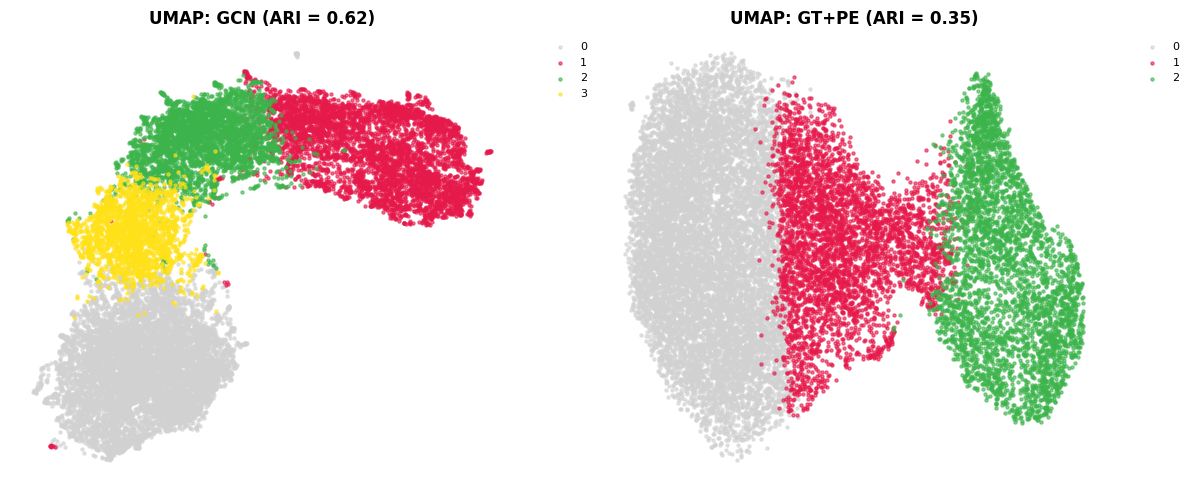

In [16]:
# Plot UMAP comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# UMAP - GCN
ax = axes[0]
clusters_gcn = adata_result_gcn.obs['Cluster_gcn'].values
for i, cluster in enumerate(np.unique(clusters_gcn)):
    mask = clusters_gcn == cluster
    ax.scatter(adata_result_gcn.obs['umap_x'][mask], 
               adata_result_gcn.obs['umap_y'][mask],
               c=plot_colors[i % len(plot_colors)], label=str(cluster), 
               s=5, alpha=0.6)
ax.set_title(f'UMAP: GCN (ARI = {best_ari_gcn:.2f})', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
ax.axis('off')

# UMAP - GT+PE
ax = axes[1]
clusters_gt_pe = adata_result_gt_pe.obs['Cluster_gt_pe'].values
for i, cluster in enumerate(np.unique(clusters_gt_pe)):
    mask = clusters_gt_pe == cluster
    ax.scatter(adata_result_gt_pe.obs['umap_x'][mask],
               adata_result_gt_pe.obs['umap_y'][mask],
               c=plot_colors[i % len(plot_colors)], label=str(cluster),
               s=5, alpha=0.6)
ax.set_title(f'UMAP: GT+PE (ARI = {best_ari_gt_pe:.2f})', fontweight='bold')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, fontsize=8)
ax.axis('off')

plt.tight_layout()
plt.savefig('MOB_UMAP_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Modality Weight Analysis

Modality Weight Analysis


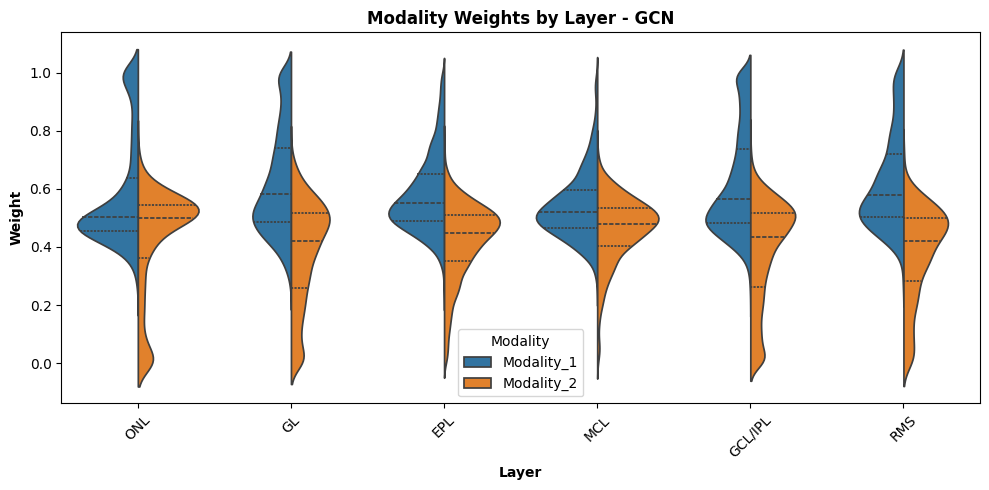


GCN - Modality Weight Statistics:
  Modality 1: mean=0.600, std=0.167
  Modality 2: mean=0.400, std=0.167


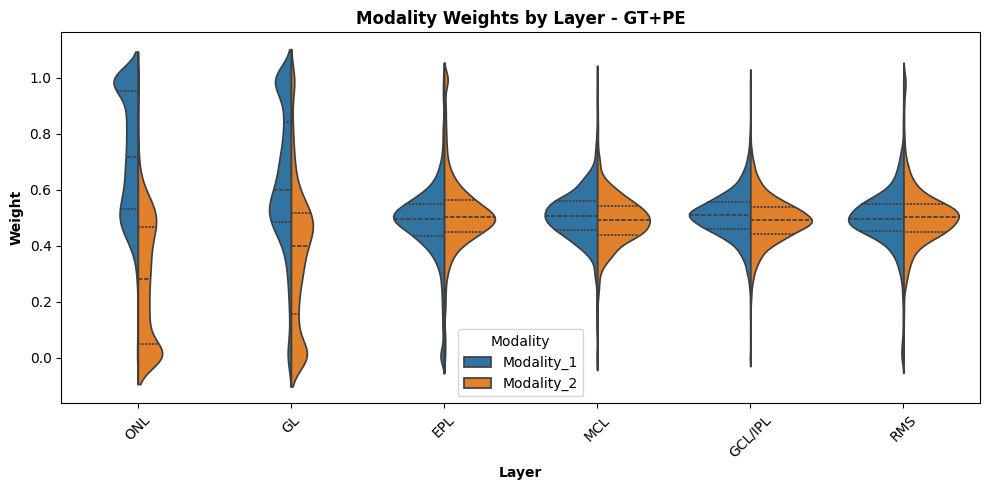


GT+PE - Modality Weight Statistics:
  Modality 1: mean=0.549, std=0.177
  Modality 2: mean=0.451, std=0.177


In [17]:
def plot_weight_analysis(weights, layer_labels, title_suffix):
    """Plot modality weight distribution by layer"""
    df = pd.DataFrame({
        'Modality_1': weights[:, 0],
        'Modality_2': weights[:, 1],
        'Layer': layer_labels
    })
    
    df_melted = df.melt(id_vars=['Layer'], var_name='Modality', value_name='Weight')
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    sns.violinplot(data=df_melted, x='Layer', y='Weight', hue='Modality',
                   split=True, inner='quart', ax=ax)
    ax.set_title(f'Modality Weights by Layer - {title_suffix}', fontweight='bold')
    ax.set_xlabel('Layer', fontweight='bold')
    ax.set_ylabel('Weight', fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"\n{title_suffix} - Modality Weight Statistics:")
    print(f"  Modality 1: mean={weights[:, 0].mean():.3f}, std={weights[:, 0].std():.3f}")
    print(f"  Modality 2: mean={weights[:, 1].mean():.3f}, std={weights[:, 1].std():.3f}")

print("=" * 60)
print("Modality Weight Analysis")
print("=" * 60)

plot_weight_analysis(weights_gcn, layer_annotations, "GCN")
plot_weight_analysis(weights_gt_pe, layer_annotations, "GT+PE")

## 12. Summary and Conclusions

In [18]:
print("\n" + "="*70)
print("FINAL SUMMARY: MOB Dataset Analysis")
print("="*70)

print(f"\nDataset Characteristics:")
print(f"  - Cells: {adata1.shape[0]}")
print(f"  - Modality 1 features: {adata1.shape[1]}")
print(f"  - Modality 2 features: {adata2.shape[1]}")
print(f"  - Layers: {len(np.unique(layer_annotations))}")
print(f"  - Spatial autocorrelation: {moran_i:.3f} ({complexity})")

print(f"\nPerformance Results:")
print(f"  GCN (Original):         ARI = {best_ari_gcn:.3f}")
print(f"  GT+PE (Enhanced):       ARI = {best_ari_gt_pe:.3f}")

improvement = ((best_ari_gt_pe - best_ari_gcn) / best_ari_gcn * 100) if best_ari_gcn > 0 else 0
print(f"  Relative improvement:   {improvement:+.1f}%")

if best_ari_gt_pe > best_ari_gcn:
    print(f"\n✓ GT+PE outperforms GCN by {improvement:.1f}%")
    print(f"  → This dataset benefits from global attention and topology awareness")
elif best_ari_gcn > best_ari_gt_pe:
    print(f"\n✓ GCN outperforms GT+PE by {-improvement:.1f}%")
    print(f"  → This dataset has strong local structure (like VisualCortex)")
    print(f"  → Consider using GCN for production")
else:
    print(f"\n≈ Both methods perform similarly")
    print(f"  → Choose based on computational constraints")

print("\n" + "="*70)
print("Analysis complete! Results saved to:")
print("  - MOB_comparison_GCN_vs_GT_PE.png")
print("  - MOB_UMAP_comparison.png")
print("="*70)


FINAL SUMMARY: MOB Dataset Analysis

Dataset Characteristics:
  - Cells: 18196
  - Modality 1 features: 1500
  - Modality 2 features: 1500
  - Layers: 6
  - Spatial autocorrelation: 0.823 (simple)

Performance Results:
  GCN (Original):         ARI = 0.617
  GT+PE (Enhanced):       ARI = 0.348
  Relative improvement:   -43.6%

✓ GCN outperforms GT+PE by 43.6%
  → This dataset has strong local structure (like VisualCortex)
  → Consider using GCN for production

Analysis complete! Results saved to:
  - MOB_comparison_GCN_vs_GT_PE.png
  - MOB_UMAP_comparison.png
